In [406]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib as plt 
import markov_clustering as mc
import random
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from scipy.stats import describe
from collections import Counter

In [407]:
def count_by(df,var):
    nb = df.groupby([var],group_keys=False).size()
    nb = pd.DataFrame({var:nb.index,'nb_'+var:nb.values})
    nb = pd.merge(df,nb,on=var,how='left')
    return nb

In [408]:
tree = pd.read_csv("../bases/fap_pcs_rome.csv")
tree.columns = 'fap','fap_lab','pcs','pcs_lab','rome','qual','rome_lab'
tree = tree.filter(items=['fap','fap_lab','rome','rome_lab'])
tree['fap']= tree['fap'].fillna(method='ffill')
tree['fap_lab']= tree['fap_lab'].fillna(method='ffill')
tree = tree.dropna(subset=['rome'],axis=0)
tree = count_by(tree,'rome')
arbo = tree.filter(['rome','rome_lab'])
arbo = arbo.drop_duplicates('rome')

In [409]:
%run rome.py
romes = list(graph.keys())

In [410]:
data = pd.read_csv("../bases/rome_tension.csv")

In [411]:
data = data[['rome5','BE_id','T']]

In [412]:
data = data.pivot(index='BE_id',columns='rome5',values='T')

In [413]:
data = data.sub(data.mean(axis=1),axis=0)

Define undirected graph

In [329]:
WG = nx.Graph()
WG.add_nodes_from(romes)
weights = {}
edge, noedge = 0, 0
for rome1 in romes:
    weights[rome1] = {}
    s = 0
    for rome2 in graph[rome1]:
        corr = data[rome1].corr(data[rome2])
        if corr > 0: # replace by rome1[0] = rome2[0]
            weights[rome1][rome2] = corr
            s += weights[rome1][rome2]
            edge += 1
        else: noedge += 1
    for rome2 in weights[rome1].keys():
        weights[rome1][rome2] =  weights[rome1][rome2]/s

for rome1 in romes:
    current_edges = list(WG.edges)
    for rome2 in weights[rome1].keys():
        if rome1 not in weights[rome2].keys(): w = weights[rome1][rome2]/2
        if rome1 in weights[rome2].keys(): w = (weights[rome1][rome2]+weights[rome2][rome1])/2
        if (rome2,rome1) not in current_edges:
                WG.add_edge(rome1,rome2,weight=w)
                
matrix = nx.adjacency_matrix(WG)

In [414]:
EG = nx.Graph()
EG.add_nodes_from(romes)
weights = {}
edge, noedge = 0, 0
for rome1 in romes:
    weights[rome1] = {}
    s = 0
    for rome2 in graph[rome1]:
        corr = np.exp(data[rome1].corr(data[rome2]))
        weights[rome1][rome2] = corr
        s += weights[rome1][rome2]
    for rome2 in weights[rome1].keys():
        weights[rome1][rome2] =  weights[rome1][rome2]/s

for rome1 in romes:
    current_edges = list(EG.edges)
    for rome2 in weights[rome1].keys():
        if rome1 not in weights[rome2].keys(): w = weights[rome1][rome2]/2
        if rome1 in weights[rome2].keys(): w = (weights[rome1][rome2]+weights[rome2][rome1])/2
        if (rome2,rome1) not in current_edges:
                EG.add_edge(rome1,rome2,weight=w)
                
matrix = nx.adjacency_matrix(EG)

In [323]:
G = nx.Graph()
G.add_nodes_from(romes)
weights = {}

for rome1 in romes:
    current_edges = list(G.edges)
    for rome2 in graph[rome1]:
        if (rome1,rome2) not in current_edges:
            if rome1 in graph[rome2]:
                w = 1.0
            else: 
                w = 0.5
            G.add_edge(rome1,rome2,weight=w)
                
matrix = nx.adjacency_matrix(G)

**Run MCL algorithm for different inflation parameters:** 

In [418]:
inflations = [round(1.1 + i/10,ndigits=1) for i in range(10)]
results = {'clusters':{},
           'lonely':{},
           'mean_size':{},
           'median_size':{},
           'max_size':{},
           'var_size':{},
           'average_within':{},
           'average_shortest_path':{}}
clustered_romes = pd.DataFrame()
clustered_romes['rome'] = romes
store_CL = {}
for inf in inflations:
    result = mc.run_mcl(matrix,inflation=inf)
    clusters = mc.get_clusters(result)
    CL = [[romes[x] for x in c] for c in clusters]
    store_CL[inf] = CL 
    results['clusters'][inf] = len(CL)
    results['lonely'][inf] = sum([len(cl) == 1 for cl in CL])
    results['mean_size'][inf] = np.mean([len(c) for c in CL])
    results['median_size'][inf] = np.median([len(c) for c in CL])
    results['max_size'][inf] = np.max([len(c) for c in CL])
    results['var_size'][inf] = np.var([len(c) for c in CL])
    results['average_within'][inf] = 0
    results['average_shortest_path'][inf] = 0
    
    clusters = []
    groups = []
    shortest = []
    
    s = 0
    for i, clus in enumerate(CL):
        clusters += clus
        groups += [i+1]*len(clus)
        s += len(clus)
        results['average_within'][inf] += data.filter(clus).mean().values.var()/(results['clusters'][inf]-results['lonely'][inf])
        n = 0
        p = 0
        for c in combinations(clus,2):
            p += nx.shortest_path_length(G,c[0],c[1])
            n += 1
        if n > 0: 
            shortest +=  [p/n]*len(clus)
            results['average_shortest_path'][inf] += (p/n)*len(clus)/len(romes)
        else : shortest +=  [0]*len(clus)
    tmp = pd.DataFrame()
    tmp['rome'] = clusters
    tmp[f'group_{inf}'] = groups
    tmp[f'shortest_{inf}'] = shortest
    tmp = tmp.sort_values('rome')
    clustered_romes = pd.merge(clustered_romes,tmp,on='rome',how='right')
    for key in ['mean_size','median_size','average_shortest_path','max_size']:
        results[key][inf] = round(results[key][inf],ndigits=1)
    results['average_within'][inf] = round(results['average_within'][inf],ndigits = 4)
    results['lonely'][inf] = results['lonely'][inf]/results['clusters'][inf]
    

In [419]:
pd.DataFrame(results).to_latex('../results/mcl_results_exp_fe.tex')

In [420]:
pd.DataFrame(results)

,clusters,lonely,mean_size,median_size,max_size,var_size,average_within,average_shortest_path
1.1,19,0.631579,28.0,1.0,151,2536.736842,0.0032,3.8
1.2,36,0.361111,14.8,8.0,134,547.561728,0.0027,3.1
1.3,67,0.208955,7.9,6.0,48,54.862107,0.0022,2.1
1.4,125,0.192000,4.3,4.0,31,11.694464,0.0017,1.5
1.5,173,0.236994,3.1,3.0,14,3.687995,0.0016,1.3
1.6,220,0.295455,2.4,2.0,7,1.725124,0.0014,1.1
1.7,256,0.371094,2.1,2.0,6,1.220459,0.0013,0.9
1.8,293,0.477816,1.8,2.0,6,0.983098,0.0011,0.8
1.9,323,0.544892,1.6,1.0,6,0.754689,0.0011,0.7
2.0,344,0.607558,1.5,1.0,6,0.666441,0.0011,0.6


ADD LABELS

In [379]:
clustered_romes = pd.merge(clustered_romes,arbo,on='rome',how='left')
clustered_romes.loc[clustered_romes.rome == 'L1510','rome_lab'] = "Films d'animation et effets spéciaux"

SAVE RESULTS 

In [380]:
for i in inflations: 
    tmp = clustered_romes.filter(['rome',f'group_{i}',f'shortest_{i}','rome_lab'])
    tmp.columns = 'rome', 'group','shortest','rome_lab'
    tmp = tmp.sort_values('group').reset_index(drop=True)
    tmp = tmp.filter(['rome','group','rome_lab','shortest'])
    index = str(i)
    index = index.replace('.','_')
    tmp.to_csv(f'../results/clustered_romes_{index}_exp_fe.csv',index=False)

**SELECT SPECIFICATION AND COMPUTE CONNEX GROUPS**

In [381]:
clustered_romes = pd.read_csv('../results/clustered_romes_1_5_exp_fe.csv')
clusters = clustered_romes.group.unique().tolist()
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}


In [382]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(clustered_romes)

      rome  group                                           rome_lab  shortest
0    E1106      1                   Journalisme et information média  1.000000
1    E1108      1                         Traduction, interprétariat  1.000000
2    E1107      2                        Organisation d'événementiel  1.600000
3    E1103      2                                      Communication  1.600000
4    E1402      2                          Élaboration de plan média  1.600000
5    M1101      2                                             Achats  1.600000
6    E1401      2            Développement et promotion publicitaire  1.600000
7    E1104      3                 Conception de contenus multimédias  1.333333
8    E1205      3                Réalisation de contenus multimédias  1.333333
9    E1306      3                                          Prépresse  1.333333
10   H1204      3                                  Design industriel  1.333333
11   E1105      4                             Coordi

In [383]:
cluster_groups

{1: ['E1106', 'E1108'],
 2: ['E1107', 'E1103', 'E1402', 'M1101', 'E1401'],
 3: ['E1104', 'E1205', 'E1306', 'H1204'],
 4: ['E1105', 'E1305'],
 5: ['L1304', 'L1301', 'L1510', 'E1102'],
 6: ['G1202', 'E1101', 'K1601'],
 7: ['H1502', 'H1302', 'H2502', 'H1101', 'I1102', 'H1501'],
 8: ['I1103', 'I1603', 'I1607', 'I1604', 'I1605'],
 9: ['G1702', 'N4103', 'N4105', 'N4104', 'N4102'],
 10: ['I1101', 'F1106', 'F1201', 'F1101', 'F1108'],
 11: ['N1105', 'N4101', 'N1102', 'L1506'],
 12: ['H1210', 'H1201', 'J1302', 'H1503', 'H1505'],
 13: ['F1103', 'H1303', 'H1506', 'H1301'],
 14: ['H1504', 'H1209', 'H1208'],
 15: ['C1106', 'C1108', 'C1107', 'C1110', 'C1104', 'C1103'],
 16: ['M1707', 'C1204', 'C1105', 'K2401', 'M1705', 'C1101', 'M1703', 'M1403'],
 17: ['C1203', 'C1102', 'D1402', 'D1404', 'C1206'],
 18: ['K1902', 'K1903', 'M1607', 'C1109', 'M1608', 'K1901'],
 19: ['H2803', 'H3201', 'H2802'],
 20: ['J1202', 'J1201', 'J1102', 'K2108', 'J1101'],
 21: ['H2805', 'H2701', 'H2801', 'H2301', 'H2804'],
 22: ['

In [384]:
purged_graph = {}
for rome, romes in graph.items():
    g = clustered_romes.loc[clustered_romes.rome == rome,'group'].values.tolist()[0]
    group = clustered_romes.loc[clustered_romes.group == g,'rome'].values.tolist()
    purged_graph[rome] = [x for x in romes if x not in group]

In [385]:
herfs = {}
groups = cluster_groups.keys()
for i,group in cluster_groups.items():
    dist = {}
    for j in groups:
        dist[j] = 0 
        for rome1 in group:
            dist[j] += sum([rome2 in cluster_groups[j] for rome2 in purged_graph[rome1]])
    tot = sum(dist.values())
    if tot > 0:
        dist = {j:(v/tot)**2 for j,v in dist.items()}
        herfs[i] = int(round(1/sum(dist.values())))
    else: 
        herfs[i] = 0

In [386]:
data = pd.read_csv("../bases/rome_tension.csv")
data = data[['rome5','BE_id','T']]
data_means = data.groupby('BE_id').mean()
data_means['BE_id'] = data_means.index
data_means = data_means.reset_index(drop=True).rename(columns = {'T':'mean'})
data=pd.merge(data,data_means,how='left',on='BE_id')
data['T'] = data['T'] - data['mean']
data = data[['rome5','BE_id','T']].rename(columns = {'rome5':'rome'})
data = pd.merge(data,clustered_romes,on='rome',how='left')
data = data.groupby(['group','BE_id']).mean().reset_index(level=['BE_id','group'])
data.BE_id = data.BE_id.astype(str)
data = data.pivot(index='BE_id',columns='group',values='T')

In [387]:
clustered_graph = {}
for i,group in cluster_groups.items(): 
    clustered_graph[i] = []
    for rome in group:
        clustered_graph[i] += [j for j, clus in cluster_groups.items() if list(set(clus) & set(graph[rome])) != [] and j != i ]
    clustered_graph[i] = list(set(clustered_graph[i]))

In [388]:
clustered_graph_length = {i:len(v) for i,v in clustered_graph.items()}
ok = {i: clustered_graph_length[i] >= v for i,v in herfs.items()}
all(ok.values())

True

In [389]:
clustered_graph_ordered = {}
clustered_graph_trimmed = {}
for i,connex in clustered_graph.items():
    correlations = {}
    for j in connex: 
        correlations[j] = data[i].corr(data[j])
    correlations = dict(sorted(correlations.items(),key=lambda x: x[1],reverse=True))
    clustered_graph_ordered[i] = list(correlations.keys())
    clustered_graph_trimmed[i] = clustered_graph_ordered[i][0:herfs[i]]

In [390]:
np.std([len(connex) for connex in graph.values()])

2.3172559986371986

In [391]:
np.mean([len(connex) for connex in purged_graph.values()])

1.9116541353383458

In [392]:
np.mean([len(connex) for connex in clustered_graph.values()])

4.283236994219653

In [393]:
graph_lengths = Counter([len(connex) for connex in graph.values()])
purged_graph_lengths = Counter([len(connex) for connex in purged_graph.values()])
clustered_graph_lengths = Counter([len(connex) for connex in clustered_graph.values()])
clustered_graph_trimmed_lengths = Counter([len(connex) for connex in clustered_graph_trimmed.values()])

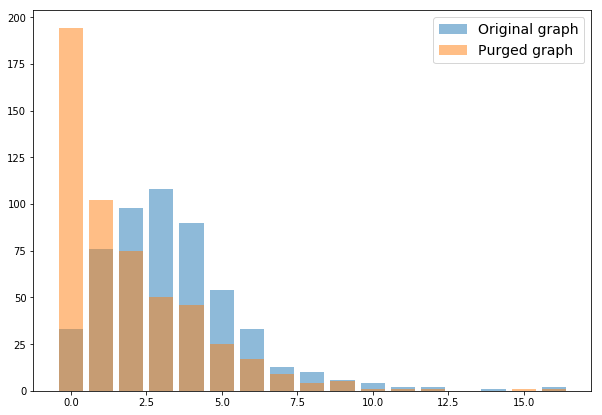

In [394]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(graph_lengths.keys(),graph_lengths.values(),alpha=0.5)
axs.bar(purged_graph_lengths.keys(),purged_graph_lengths.values(),alpha=0.5)
axs.legend(['Original graph','Purged graph'],prop={'size':14})
fig.savefig('../results/connex_romes.png')

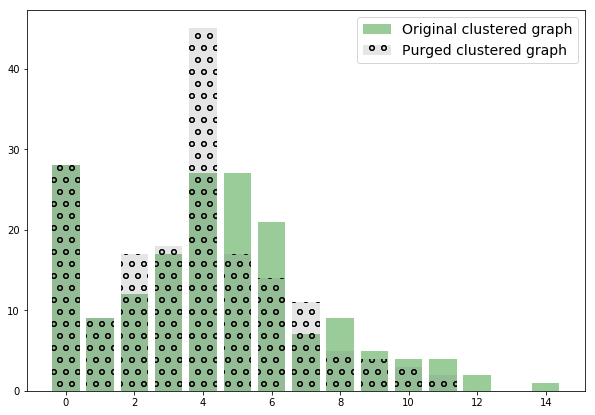

In [395]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(clustered_graph_lengths.keys(),clustered_graph_lengths.values(),color='g',alpha=0.4)
axs.bar(clustered_graph_trimmed_lengths.keys(),clustered_graph_trimmed_lengths.values(),color='0.5',alpha=0.2,ecolor='black',hatch='o')
axs.legend(['Original clustered graph','Purged clustered graph'],prop={'size':14})
fig.savefig('../results/connex_clusters.png')

In [398]:
clustered_romes = pd.read_csv('../results/clustered_romes_2_1_no_weights.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_no_weight = Counter([len(group) for group in cluster_groups.values()])

clustered_romes = pd.read_csv('../results/clustered_romes_1_3_fe.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_fe = Counter([len(group) for group in cluster_groups.values()])

clustered_romes = pd.read_csv('../results/clustered_romes_1_5_exp_fe.csv')
clusters = clustered_romes.group.unique().tolist()
print(len(clusters))
cluster_groups = {i+1:clustered_romes.loc[clustered_romes.group == clus, 'rome'].tolist() for i, clus in enumerate(clusters)}
cluster_size_exp_fe = Counter([len(group) for group in cluster_groups.values()])

143
153
173


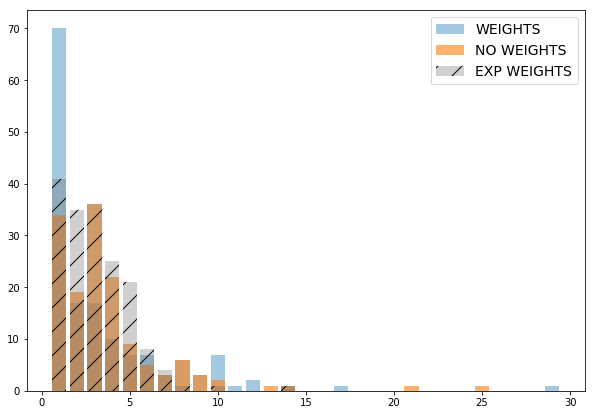

In [402]:
fig, axs = plt.subplots(sharex=True,figsize=(10,7))
axs.bar(cluster_size_fe.keys(),cluster_size_fe.values(),alpha=0.4)
axs.bar(cluster_size_no_weight.keys(),cluster_size_no_weight.values(),alpha=0.6)
axs.bar(cluster_size_exp_fe.keys(),cluster_size_exp_fe.values(),color='0.4',hatch='/',alpha=0.3)
axs.legend(['WEIGHTS','NO WEIGHTS','EXP WEIGHTS'],prop={'size':14})
fig.savefig('../results/cluster_sizes.png')

In [404]:
{i:len(group) for i, group in cluster_groups.items()}

{1: 2,
 2: 5,
 3: 4,
 4: 2,
 5: 4,
 6: 3,
 7: 6,
 8: 5,
 9: 5,
 10: 5,
 11: 4,
 12: 5,
 13: 4,
 14: 3,
 15: 6,
 16: 8,
 17: 5,
 18: 6,
 19: 3,
 20: 5,
 21: 5,
 22: 2,
 23: 4,
 24: 14,
 25: 1,
 26: 7,
 27: 3,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 3,
 33: 3,
 34: 3,
 35: 1,
 36: 4,
 37: 1,
 38: 4,
 39: 6,
 40: 1,
 41: 3,
 42: 5,
 43: 1,
 44: 1,
 45: 2,
 46: 3,
 47: 7,
 48: 3,
 49: 2,
 50: 5,
 51: 1,
 52: 2,
 53: 3,
 54: 3,
 55: 4,
 56: 1,
 57: 2,
 58: 5,
 59: 5,
 60: 2,
 61: 2,
 62: 5,
 63: 6,
 64: 4,
 65: 1,
 66: 1,
 67: 5,
 68: 1,
 69: 5,
 70: 2,
 71: 3,
 72: 4,
 73: 2,
 74: 6,
 75: 4,
 76: 1,
 77: 3,
 78: 3,
 79: 4,
 80: 1,
 81: 4,
 82: 4,
 83: 1,
 84: 3,
 85: 5,
 86: 2,
 87: 2,
 88: 3,
 89: 1,
 90: 7,
 91: 3,
 92: 3,
 93: 4,
 94: 3,
 95: 2,
 96: 2,
 97: 4,
 98: 3,
 99: 2,
 100: 3,
 101: 4,
 102: 5,
 103: 4,
 104: 1,
 105: 3,
 106: 1,
 107: 10,
 108: 7,
 109: 1,
 110: 2,
 111: 3,
 112: 2,
 113: 3,
 114: 3,
 115: 2,
 116: 2,
 117: 2,
 118: 4,
 119: 6,
 120: 4,
 121: 1,
 122: 3,
 123: 2,